In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from tqdm import tqdm
sns.set_style('whitegrid')

In [2]:
## hard code values

stocks = ["LUPIN.NS", "VOLTAS.NS", "YESBANK.NS"]
NUM_OF_SIMULATIONS = 5000
INITIAL_AMT_INVESTED = 10000

In [3]:
## A FUNCTION TO RETRIEVE INFORMATION FOR A GIVEN LIST OF STOCKS

def fetch_data(stock_list, start_date, end_date):
    
    if type(stock_list)!=list:
        stock_list = [stock_list]
    
    for i in range(len(stock_list)):
        stock_list[i] = stock_list[i].upper()

    stock_data = {}
    for stock in stock_list:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
        
    return pd.DataFrame(stock_data)

In [4]:
## GATHER STOCK PRICES

stock_prices = fetch_data(stocks, start_date='2023-01-01', end_date='2023-12-31')


## CALCULATE LOG RETURNS

log_returns = np.log(stock_prices/stock_prices.shift(1))
log_returns = log_returns[1:]

In [9]:
portfolio_weights = []
portfolio_returns = []
portfolio_risks = []
NUM_TRADING_DAYS = len(stock_prices)


## MONTE CARLO SIMULATION

for i in tqdm(range(NUM_OF_SIMULATIONS)):
    
    ## STEP-I: generating random weights
    w = np.random.rand(log_returns.shape[1])
    w = np.expand_dims(w, axis=0)
    w = w/np.sum(w)
    portfolio_weights.append(w)
    
    ## STEP-II: calculating returns using average annual returns
    p_returns = (log_returns.mean() @ w.T*NUM_TRADING_DAYS)[0]
    portfolio_returns.append(p_returns)
    
    ## STEP-III: calculating risks
    p_risks = np.sqrt(w @ log_returns.cov()*NUM_TRADING_DAYS @ w.T)[0][0]
    portfolio_risks.append(p_risks)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1581.28it/s]


In [18]:
portfolio_weights = np.array(portfolio_weights)
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)

## CALCULATING SHARPE RATIO

# taking IR of government issued 10-year bonds as risk-free rate
risk_free_rate = 0.07

sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_risks

In [19]:
## OPTIMIZED WEIGHTS

index = np.argmax(sharpe_ratios)
optimized_weights = portfolio_weights[index].flatten()

num_of_shares = INITIAL_AMT_INVESTED*optimized_weights/stock_prices.iloc[0,:]
num_of_shares = np.expand_dims(num_of_shares, axis=0)

In [20]:
## CALCULATING PORTFOLIO VALUE
portfolio_value = np.sum(num_of_shares*np.array(stock_prices), axis=1)

## PORTFOLIO DATAFRAME
df_portfolio = num_of_shares*stock_prices
df_portfolio['PORTFOLIO_VALUE'] = portfolio_value

<Axes: xlabel='Date'>

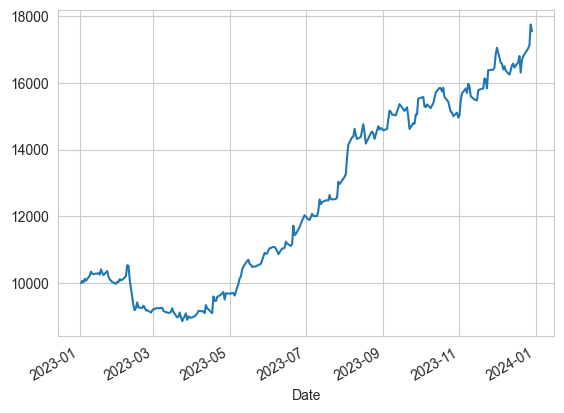

In [21]:
df_portfolio['PORTFOLIO_VALUE'].plot()

In [24]:
## CORRELATION MATRIX

correlation_matrix = log_returns.corr()
correlation_matrix

,LUPIN.NS,VOLTAS.NS,YESBANK.NS
LUPIN.NS,1.000000,0.111108,0.127756
VOLTAS.NS,0.111108,1.000000,0.055763
YESBANK.NS,0.127756,0.055763,1.000000


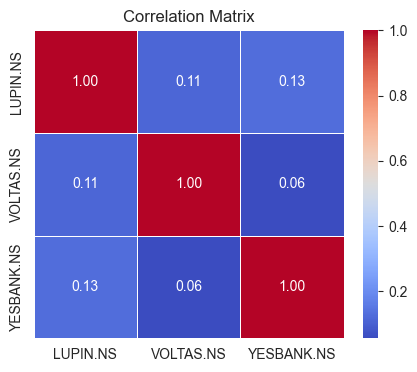

In [25]:
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()